In [30]:
from sklearn.datasets import load_iris  
import numpy as np
from IrisFisher import softmax, softmax_grad, logloss, sigmoid
import matplotlib.pyplot as plt
from seaborn import pairplot
from pandas import DataFrame

In [4]:
data = load_iris()

In [ ]:
def UnisonShuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def random_init(size, left = -0.1, right = 0.1):
    return np.random.random(size = size) * (right + left) + left

def net_init_1(params):
    params["L0"] = np.zeros((1, 4))

    params["W0"] = random_init((4, 4))
    params['b0'] = random_init((1, 4))

    params["L1"] = np.zeros((1, 4))
    params["P1"] = np.zeros((1, 4))
    
    params["W1"] = random_init((4, 3))
    params['b1'] = random_init((1, 3))
    
    params["L2"] = np.zeros((1, 3))
    params["P2"] = np.zeros((1, 3))
    
    params["E"] = np.zeros((1,1))
    
def check_shape_1(X, y):
    if X.shape !=  (1, 4):
        raise ValueError("X : Expect shape (1, 4), given {0}".format(X.shape))
    if y.shape !=  (1, 3):
        raise ValueError("X : Expect shape (1, 3), given {0}".format(y.shape))

def normalize_to_segment(X): # to [0, 1]
    X -= np.min(X)
    return X / np.max(X) 

In [5]:
def forward_prop_1(X, y, params):
    check_shape_1(X, y)
    
    params["L0"] = X

    params["L1"] = np.dot(params["L0"], params["W0"]) + params["b0"]
    params["P1"] = sigmoid(params["L1"])
    
    # params["P1"] = X
    
    params["L2"] = np.dot(params["P1"], params["W1"]) + params["b1"]
    params["P2"] = softmax(params["L2"])
    
    params["E"] = logloss(params["P2"], y)
    
def back_prop_1(X, y, params, giper_params):
    check_shape_1(X, y)
    
    params["dE/dP2"] = - y / params["P2"] # 1x3
    params["dP2/dL2"] = softmax_grad(params["P2"]) # 3x3
    params["dE/dL2"] = np.dot(params["dE/dP2"], params["dP2/dL2"]) # 1x3
    params["dE/dW1"] = np.dot(params["P1"].T, params["dE/dL2"]) #4x3
    params["dE/db1"] = params["dE/dL2"]
    
    params["dE/dP1"] = np.dot(params["dE/dL2"], params["W1"].T)# 1x4
    params["dP1/dL1"] = params["P1"] * (1 - params["P1"]) #1x4
    params["dE/dL1"] = params["dE/dP1"] * params["dP1/dL1"] # 1x4
    # params["dE/dL1"] = np.dot(params["dE/dL2"], params["W1"].T)
    params["dE/dW0"] = np.dot(params["L0"].T, params["dE/dL1"]) # 4x4
    params["dE/db0"] = params["dE/dL1"]
    
    params["W1"] -= giper_params["learning rate"] * params["dE/dW1"]
    params["b1"] -= giper_params["learning rate"] * params["dE/db1"]
    
    params["W0"] -= giper_params["learning rate"] * params["dE/dW0"]
    params["b0"] -= giper_params["learning rate"] * params["dE/db0"]
    

In [47]:
X = data["data"]
y_lables = data["target"]

X, y_lables = UnisonShuffle(X, y_lables)

y = np.zeros((len(y_lables), 3))
for i, a in enumerate(y_lables):
    y[i][a] = 1

TEST_SIZE = 30

df= DataFrame(X)
df["labels"] = y_lables

np.random.seed(1)
test = np.random.choice(149, TEST_SIZE, replace=False)
# X = normalize_to_segment(X)
dfN= DataFrame(X)
dfN["labels"] = y_lables

X = X.reshape(-1, 1, 4)
y = y.reshape(-1, 1, 3)
X_test = X[test]
y_test = y[test]
X = X[~test]
y = y[~test]


params = dict()
giper_params = dict()
giper_params["learning rate"] = 0.01
lenX = len(y)

# pairplot(df, vars=[0, 1, 2, 3],  hue="labels")
# pairplot(dfN, vars=[0, 1, 2, 3],  hue="labels")


net_init_1(params)
    

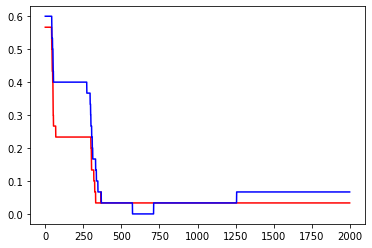

In [48]:
test_accuracy = []
train_accuracy = []
time = []

for i in range(lenX * 2000):
    X_cur = X[i % lenX]
    y_cur = y[i % lenX]
    forward_prop_1(X_cur, y_cur, params)
    back_prop_1(X_cur, y_cur, params, giper_params)
    if (i % lenX) == lenX - 1:
        time.append(i // lenX)
        error_counter = 0
        for iter, item in enumerate(y_test):
            X_cur = X_test[iter]
            y_cur = y_test[iter]
            forward_prop_1(X_cur, y_cur, params)
            if np.argmax(y_cur) != np.argmax(params["P2"]):
                error_counter += 1
            # print(np.argmax(y_cur), np.argmax(params["P2"]))
            # print(params["P2"])
        test_accuracy.append(error_counter/TEST_SIZE)
        # print(error_counter/TEST_SIZE, end = "  ")
        
        error_counter = 0
        for iter, item in enumerate(y):
            X_cur = X[iter]
            y_cur = y[iter]
            forward_prop_1(X_cur, y_cur, params)
            if np.argmax(y_cur) != np.argmax(params["P2"]):
                error_counter += 1
            # print(np.argmax(y_cur), np.argmax(params["P2"]))
            # print(params["P2"])
        train_accuracy.append(error_counter/lenX)
        # print(error_counter/lenX)
    
plt.plot(time, train_accuracy, "r")
plt.plot(time, test_accuracy, "b")
plt.show()

In [24]:
print(train_accuracy)

[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5666666666666667, 0.5666666666666667, 0.5666666666666667, 0.5666666666666667, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5, 0.43333333333333335, 0.4, 0.4, 0.3333333333333333, 0.23333333333333334, 0.23333333333333334, 0.2, 0.2, 0.2, 0.2, 0.16666666666666666, 0.16666666666666666, 0.13333333333333333, 0.13333333333333333]


In [ ]:
error_counter = 0


for iter, item in enumerate(y):
    X_cur = X[iter % lenX]
    y_cur = y[iter % lenX]
    forward_prop_1(X_cur, y_cur, params)
    if np.argmax(y_cur) != np.argmax(params["P2"]):
        error_counter += 1
    # print(np.argmax(y_cur), np.argmax(params["P2"]))
    # print(params["P2"])
print(error_counter)

